In [ ]:
from google.colab import drive
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 20, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


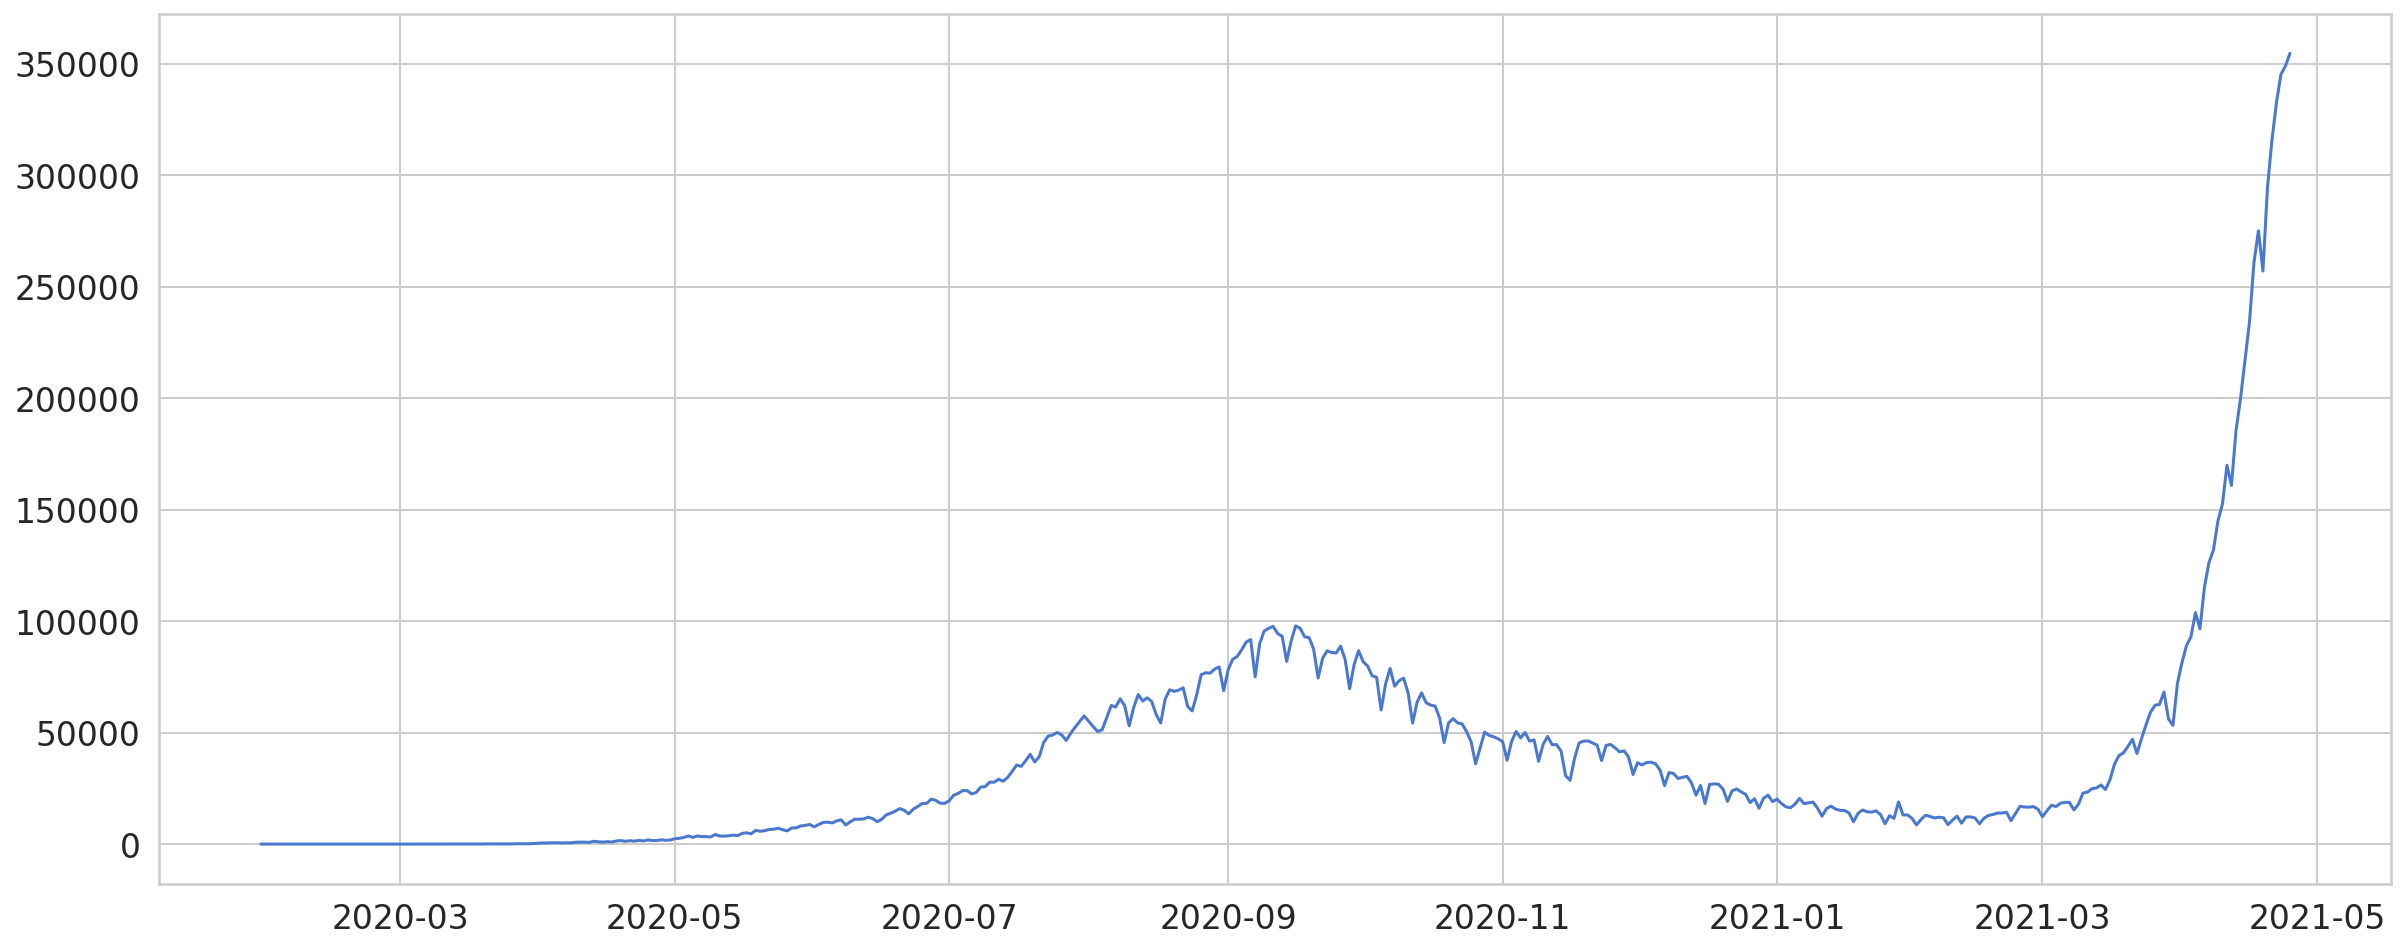

In [ ]:
file=pd.read_csv('/content/drive/MyDrive/DSanom/case_time.csv',index_col='Date',parse_dates=['Date'],usecols=['Date','Daily Confirmed'])
data=pd.read_csv('/content/drive/MyDrive/DSanom/case_time.csv',index_col='Date',parse_dates=['Date'],usecols=['Date','Daily Confirmed'])
plt.plot(file,label='Corona Cases')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(data[['Daily Confirmed']])
data[['Daily Confirmed']] = scaler.transform(data[['Daily Confirmed']])
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 30
X_train, y_train = create_dataset(data[['Daily Confirmed']],data['Daily Confirmed'], TIME_STEPS)
print(X_train.shape)

(422, 30, 1)


In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
12/12 [==============================] - 5s 107ms/step - loss: 0.4402 - val_loss: 1.1782
Epoch 2/10
12/12 [==============================] - 0s 39ms/step - loss: 0.2070 - val_loss: 1.1277
Epoch 3/10
12/12 [==============================] - 0s 38ms/step - loss: 0.2974 - val_loss: 0.7335
Epoch 4/10
12/12 [==============================] - 0s 37ms/step - loss: 0.1534 - val_loss: 0.9922
Epoch 5/10
12/12 [==============================] - 0s 40ms/step - loss: 0.1318 - val_loss: 1.0429
Epoch 6/10
12/12 [==============================] - 0s 38ms/step - loss: 0.1139 - val_loss: 0.9228
Epoch 7/10
12/12 [==============================] - 0s 39ms/step - loss: 0.1058 - val_loss: 0.9325
Epoch 8/10
12/12 [==============================] - 0s 40ms/step - loss: 0.1038 - val_loss: 0.9506
Epoch 9/10
12/12 [==============================] - 0s 36ms/step - loss: 0.0995 - val_loss: 0.8703
Epoch 10/10
12/12 [==============================] - 0s 38ms/step - loss: 0.0975 - val_loss: 0.9115


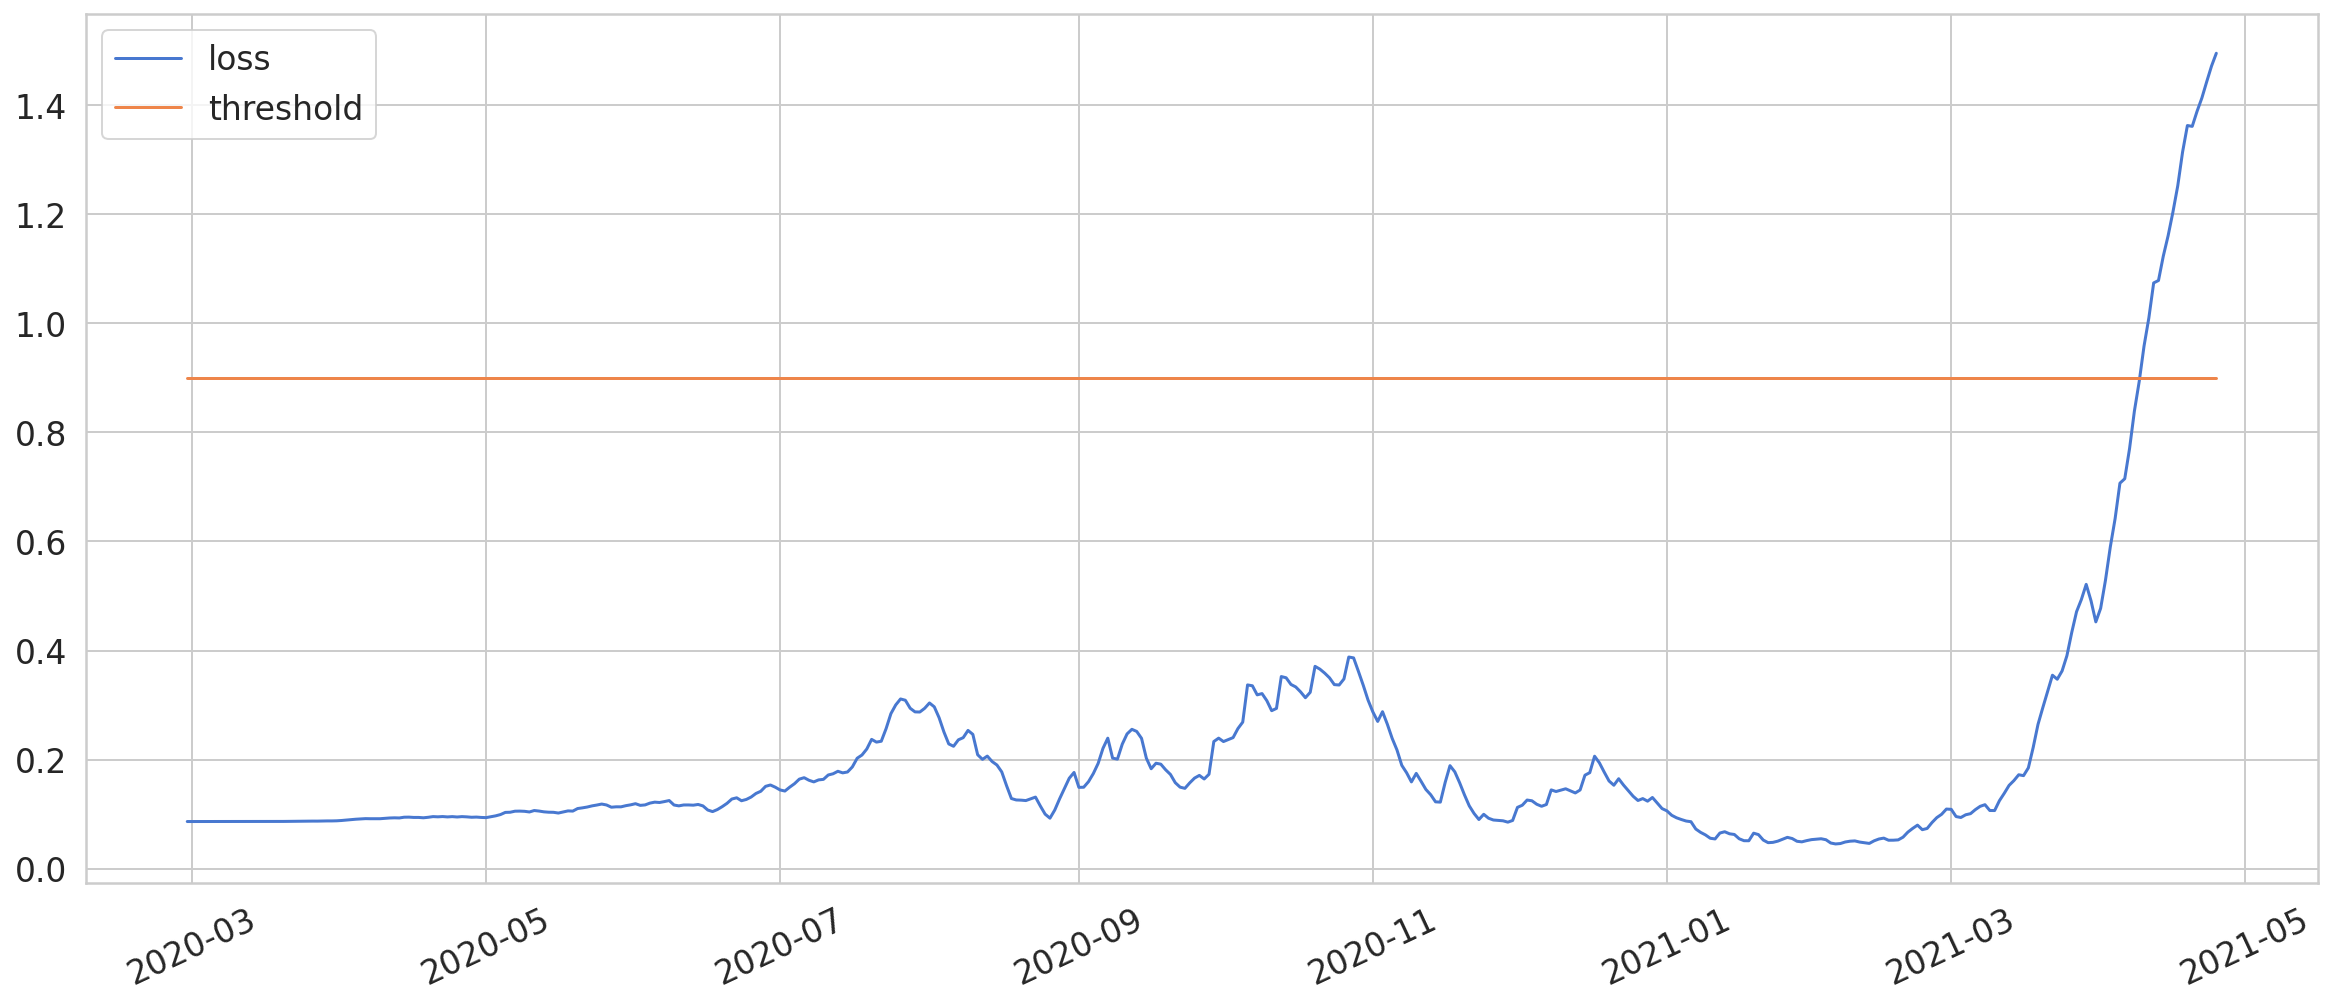

In [ ]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
THRESHOLD = 0.9

test_score_df = pd.DataFrame(index=data[TIME_STEPS:].index)
test_score_df['loss'] = train_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['DC'] = file[TIME_STEPS:]
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,DC
Date,,,,
2021-04-10,0.957898,0.9,True,152565
2021-04-11,1.009477,0.9,True,169914
2021-04-12,1.073749,0.9,True,160838
2021-04-13,1.078203,0.9,True,185297
2021-04-14,1.122957,0.9,True,199584


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


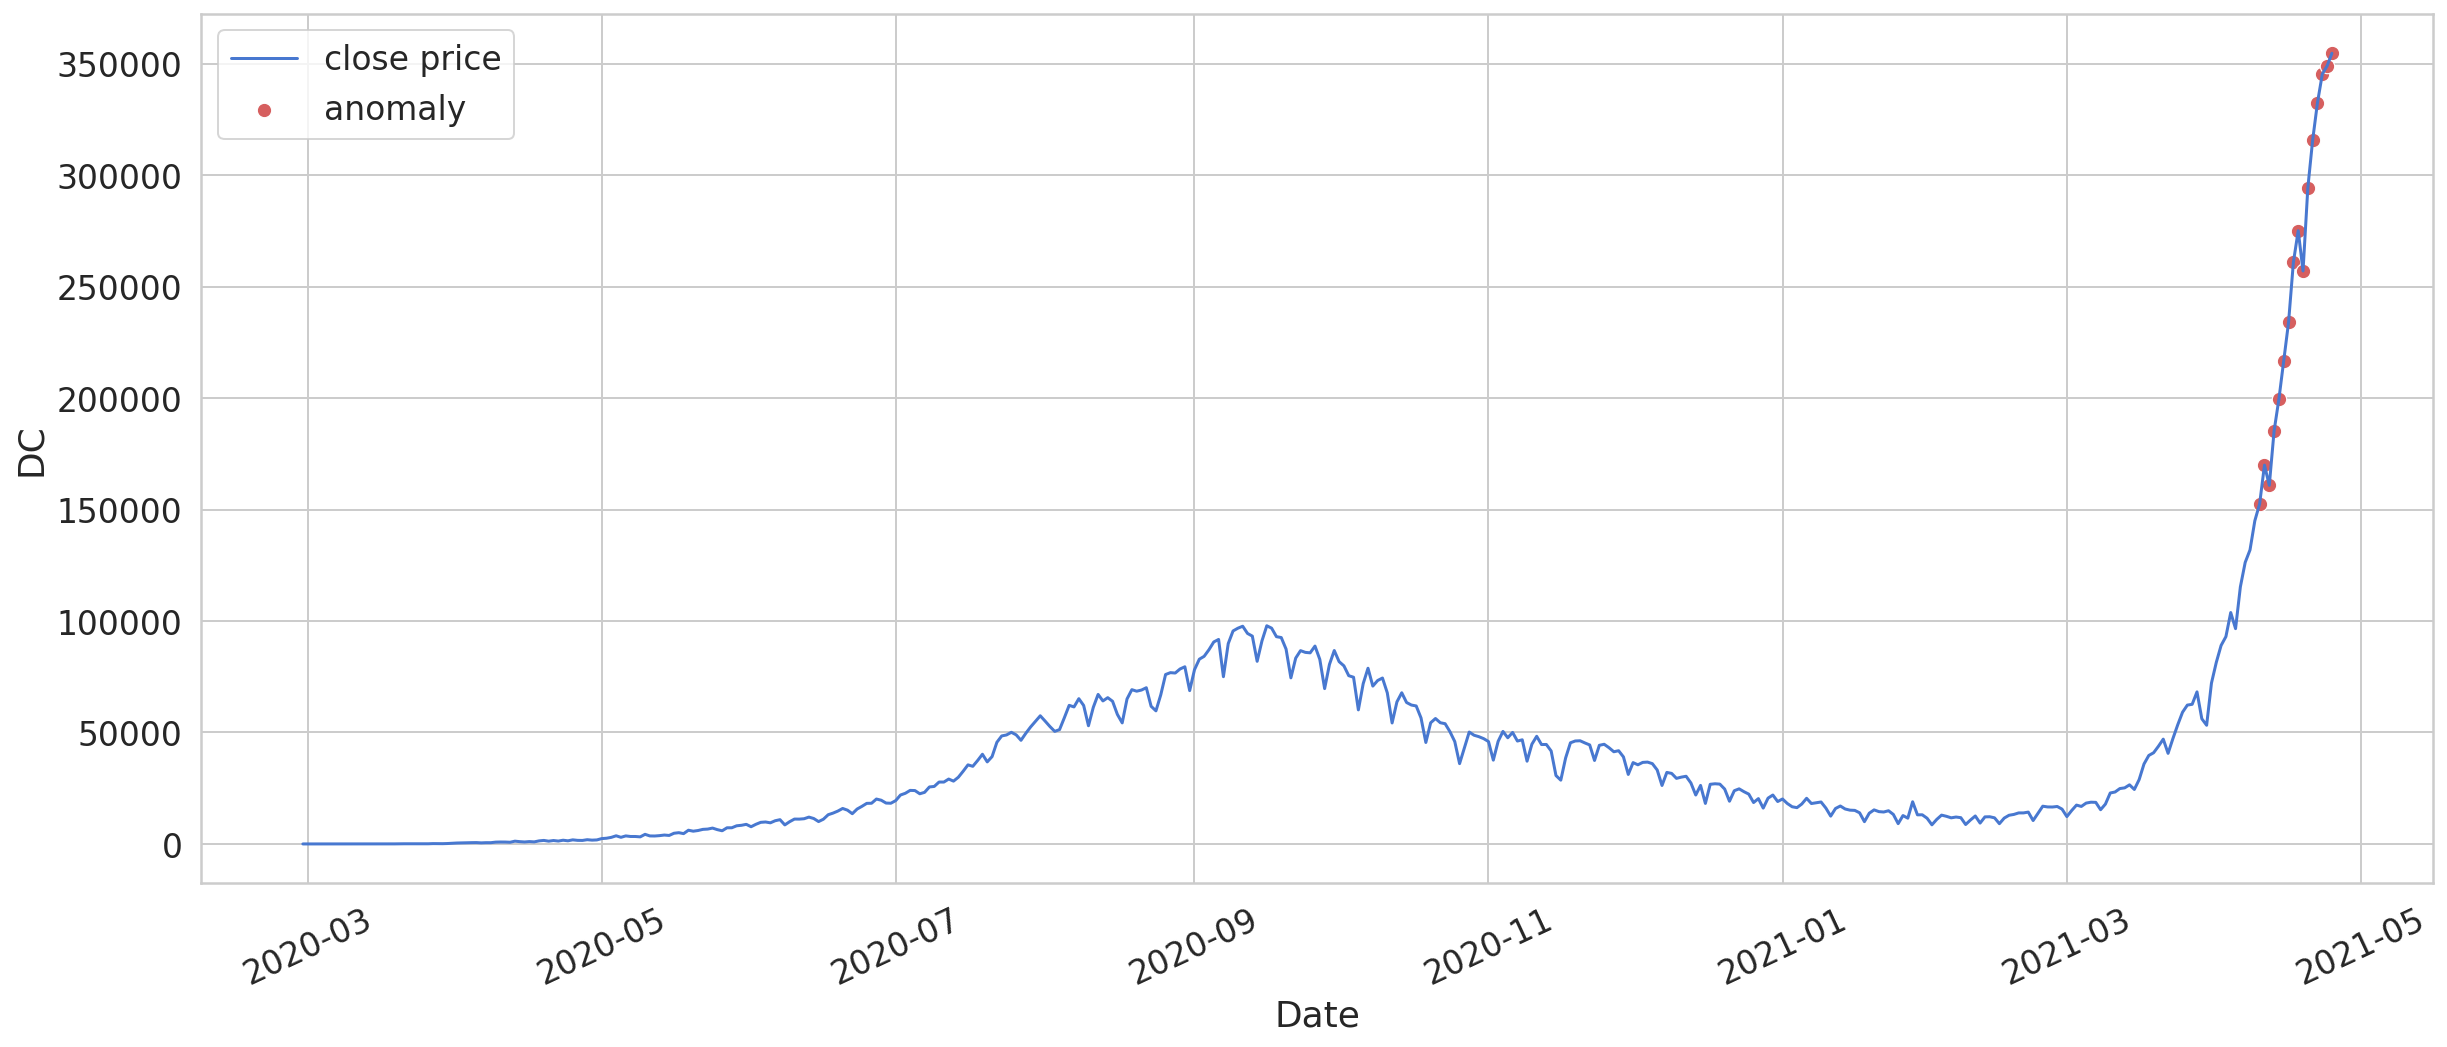

In [ ]:
plt.plot(
  file[TIME_STEPS:].index, 
  file[TIME_STEPS:], 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  anomalies.DC,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();